In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

import time, datetime, socket

import tfdiffeq

import tensorflow as tf
tf.keras.backend.set_floatx('float64')
device = 'cpu:0' 

print(f"author  {socket.gethostname():>28}")
print(f"version {str(datetime.datetime.now()):>28}")
print(f"device  {device:>28}")


author                           NOB
version   2023-06-17 19:46:56.336766
device                         cpu:0


#### load tclab measured data  

model contains random generated switching states  

In [2]:
name = "model.q.3"
fname = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name))

from _helpers import Helpers_

t,u,y,data_size = Helpers_.tfload_(fname)

print(f"data {name:>10}")
print(f"size {data_size:>10}")

data  model.q.3
size       1200


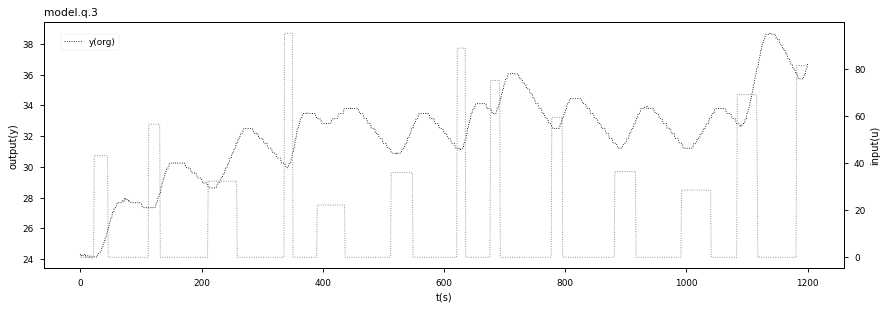

In [3]:
from _tclab import _tclabutils

t_,u_,y_ = t.numpy().flatten(),u.numpy().flatten(),y.numpy().flatten()

#snr = 50
#y_ = _tclabutils.noise_(y_,snr=snr)
#y = tf.convert_to_tensor(y_,dtype=tf.float64)

_tclabutils.plot(t_,u_,y_,title=f"{name}")


#### import (neuronal) models and helper   

_model.py contains the surrogate computation, neuronal net PINN definition

In [4]:
from _models import SurrogateODE, HelperODE, ParamsODE, NeuralPIN

#### neural net training by batch

monitoring data results and loss per iteration with optimizer adam  
batch decision to get a calm loss behaviour  
definition to receive $y_{balanced}$ prediction per iteration by linerar_fit_ function  

In [5]:
%%time

c_up,c_down = "\u23f6","\u23f7"

# iterations to train
n_iters = 10000

batch_time = 10     # time scale to 
batch_due = 0       # due to reduce data size 
                    # to a batch size
batch_size = int((data_size-batch_due)/batch_time)

print_freq = 10     # freq to print sth out

weight_data = tf.constant(0.3,dtype=tf.float64)
weight_bala = tf.constant(0.7,dtype=tf.float64)

n_iters_done = n_iters

loss_factor_eps = 0.01

print(f"iterations {n_iters}")
print(f"batch time {batch_time}, due {batch_due}, size {batch_size}")
print(f"weight data {weight_data:2.2f}, surrogate {weight_bala:2.2f}")

print(f"loss factor eps {loss_factor_eps:2.2f}")

data_monitor = []
loss_monitor = []

with tf.device(device):

    # build model
    model = NeuralPIN()
    balan = SurrogateODE(params=ParamsODE())

    lr = 1e-3
    optimizer = tf.keras.optimizers.Adam(lr)

    itime = time.time()        

    # iterate
    print(f"iter | {'delay':>8} | {'loss':>15}  {'loss(pred)':>15}  {'loss(bala)':>15}")

    for itr in range(1,n_iters+1):
        
        with tf.GradientTape() as tape:

            # batch
            batch_y0, batch_t, batch_u, batch_y, batch_i = HelperODE.batch_(
                t, u, y, 
                batch_size=batch_size, 
                batch_time=batch_time, 
                data_size=data_size)
            
            batch_d = batch_y - batch_y0

            # pin model: get T
            y_pred = model(batch_t,batch_y)

            # surrogate: get dTdt
            b_pred = balan(batch_t,batch_y,batch_u)                  
            y_bala = SurrogateODE.linear_fit_(b_pred, batch_t, batch_y0)
                                              
            # compute losses of pinn prediction
            # to given samples
            loss_data = tf.multiply(tf.reduce_mean(tf.square(batch_y - y_pred)),weight_data)
            # to surrogate model
            loss_bala = tf.multiply(tf.reduce_mean(tf.square(y_bala - y_pred)),weight_bala)

            loss_factor = loss_data / loss_bala

            loss = loss_data + loss_bala

            # monitor per iteration
            # data batches
            data_monitor.append([
                batch_i,
                y_pred.numpy().flatten(),
                y_bala.numpy().flatten()
                ])
            # loss items
            loss_monitor.append([
                loss.numpy(),
                loss_data.numpy(),
                loss_bala.numpy()
                ])
                    
        # pack loss and trainable variables of the tf model
        gg = tape.gradient(loss, model.trainable_variables)
        gv = zip(gg, model.trainable_variables)       
        
        # optimzer setup to do sth against the loss
        optimizer.apply_gradients(gv) 

        if itr % print_freq == 0:            
            
            dt = f"{time.time()-itime:5.2f}"
            
            ls = f"{loss.numpy():12.6f}"
            ld = f"{loss_data.numpy():12.6f}"
            lb = f"{loss_bala.numpy():12.6f}"
            
            # loss factor
            lf = f"{loss_factor.numpy():12.6f}"

            ds = c_down if loss.numpy() < loss_monitor[itr-print_freq-1][0] else c_up
            dd = c_down if loss_data.numpy() < loss_monitor[itr-print_freq-1][1] else c_up
            db = c_down if loss_bala.numpy() < loss_monitor[itr-print_freq-1][2] else c_up
            
            print(f"{itr:04d} | {dt:>8} | {ls:>15}{ds}{ld:>15}{dd}{lb:>15}{db}{lf:>15}")
            itime = time.time()

        if loss_factor <= loss_factor_eps:
            n_iters_done = itr
            print(f"early stopping by factor {loss_factor} decrease down to {loss_factor_eps}")
            break


iterations 10000
batch time 10, due 0, size 120
weight data 0.30, surrogate 0.70
loss factor eps 0.01
iter |    delay |            loss       loss(pred)       loss(bala)
0010 |     0.52 |      500.377864⏶     150.148061⏶     350.229804⏶       0.428713
0020 |     0.29 |      463.958590⏷     139.130246⏷     324.828345⏷       0.428319
0030 |     0.29 |      446.546562⏷     134.253124⏷     312.293437⏷       0.429894
0040 |     0.29 |      420.232866⏷     125.579442⏷     294.653425⏷       0.426194
0050 |     0.30 |      392.989183⏷     117.694282⏷     275.294901⏷       0.427521
0060 |     0.29 |      393.856181⏶     117.539588⏷     276.316593⏶       0.425380
0070 |     0.32 |      376.864690⏷     113.004035⏷     263.860655⏷       0.428272
0080 |     0.33 |      345.790925⏷     103.235883⏷     242.555043⏷       0.425618
0090 |     0.32 |      321.501272⏷      96.443832⏷     225.057441⏷       0.428530
0100 |     0.32 |      316.626977⏷      94.800912⏷     221.826065⏷       0.427366
0110 |    

#### save model of the neural pin

In [13]:
%%time 

model_name = os.path.join(os.getcwd(),"data","tclab.%s.pinn.tf"%(name))
model.save(model_name, save_format="tf")

INFO:tensorflow:Assets written to: c:\Develop\vsc\tclab\data\tclab.model.q.3.pinn.tf\assets
CPU times: total: 375 ms
Wall time: 739 ms


In [14]:
import pandas as pd
monitor_path = os.path.join(os.getcwd(),"data","tclab.%s.pinn.mo"%(name))
if not os.path.exists(monitor_path): os.mkdir(monitor_path)

data_monitor_filename = os.path.join(monitor_path,"data.monitor.pickle")
pd.DataFrame(np.array(data_monitor,dtype=object), columns=['index','y_pred','y_bala']).to_pickle(data_monitor_filename)

loss_monitor_filename = os.path.join(monitor_path,"loss.monitor.pickle")
pd.DataFrame(np.array(loss_monitor,dtype=object), columns=['loss','loss_data','loss_bala']).to_pickle(loss_monitor_filename)

print(f"data monitor size {os.path.getsize(data_monitor_filename):>10}")
print(f"loss monitor size {os.path.getsize(loss_monitor_filename):>10}")

data monitor size  185471719
loss monitor size     522998


#### plot results over data set and loss

$loss(pred)$: loss of prediction becomes lower than loss off surrogate after 2500 iterations  
an early stopping possible by factor lower than 0.8  (maybe)


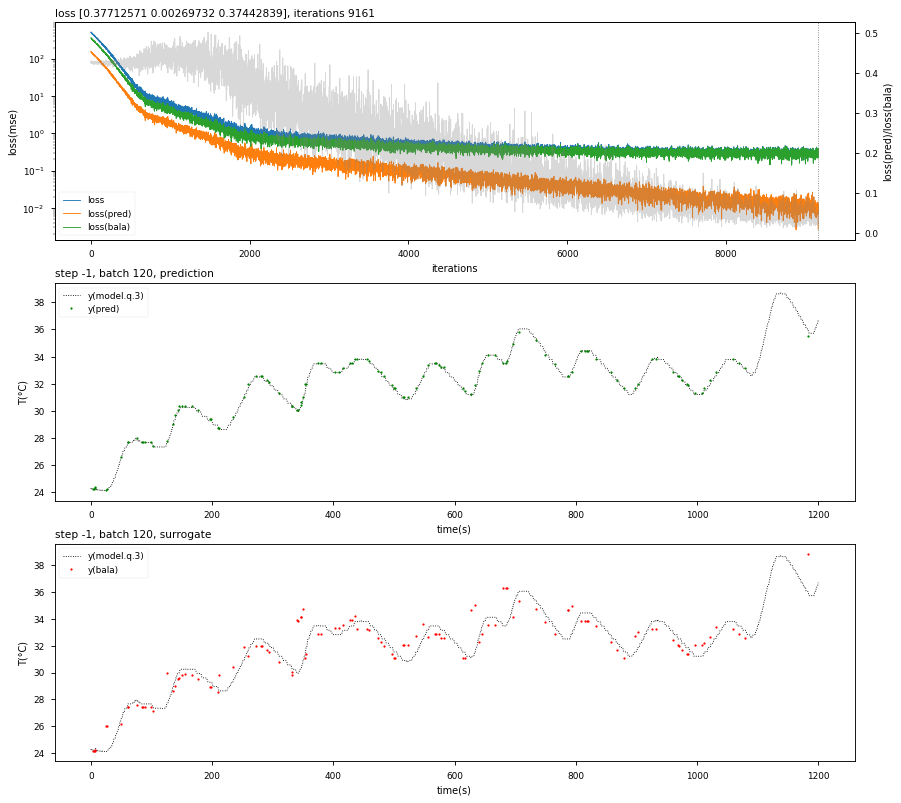

In [16]:
def plot_(data_monitor,loss_monitor,batch_size,step_number=-1,n_iters=0,weights=[1.,1.]):
    """
    plot data and loss monitor
    step_number: to swipe over results backwards
    """
    marker_size = 2

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80
    plt.rcParams["lines.linewidth"] = .8

    ncols,nrows = 1,3
    nwidth,nheight = 16,4

    fig, axx = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
    fig.subplots_adjust(right=0.75)

    ts = t.numpy().flatten()
    ys = y.numpy().flatten()

    k = step_number   

    # time by batched indizes
    i_ = data_monitor[k][0]
    t_ = ts[i_]

    # batch slices in one chain   

    # -------------------

    ax = axx[1]

    ax.plot(ts,ys,":",color="black",label="y(%s)"%(name))

    s_ = data_monitor[k][1]

    batch_number = 1
    y_ = s_[-batch_number*batch_size:len(s_)-(batch_number-1)*batch_size]
    ax.plot(t_,y_,'o',ms=marker_size,label="y(pred)",color="green")

    ax.set_xlabel("time(s)"); ax.set_ylabel("T(°C)")
    ax.legend()
    ax.set_title(f"step {step_number}, batch {batch_size}, prediction",x=0,ha="left")

    # -------------------

    ax = axx[2]

    ax.plot(ts,ys,":",color="black",label="y(%s)"%(name))

    s_ = data_monitor[k][2]
    
    y_ = s_[-batch_number*batch_size:len(s_)-(batch_number-1)*batch_size]
    ax.plot(t_,y_,'o',ms=marker_size,label="y(bala)",color="red")

    ax.set_xlabel("time(s)"); ax.set_ylabel("T(°C)")
    ax.legend()
    ax.set_title(f"step {step_number}, batch {batch_size}, surrogate",x=0,ha="left")

    # -------------------

    ax = axx[0]

    lm = np.array(loss_monitor)
    for i in range(lm.shape[1]):
        ax.plot(lm[:,i],label=f"{['loss','loss(pred)','loss(bala)'][i]}")
    
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlabel("iterations"); ax.set_ylabel("loss(mse)")
    ax.set_title(f"loss {lm[-1,:]}, iterations {n_iters}",x=0,ha="left")
    
    # swipe backwards
    ax.axvline(x=lm.shape[0]+step_number,color="grey",linestyle=":")    

    # loss factor
    ax2 = ax.twinx()
    ax2.plot(lm[:,-2]/lm[:,-1],label=f"{'loss(factor)'}",color="grey",alpha=0.3,zorder=-2)
    ax2.set_ylabel("loss(pred)/loss(bala)")

    plt.show()
    plt.close()


plot_(data_monitor, loss_monitor, batch_size, step_number=-1, n_iters=n_iters_done)


#### plot surrogate and neural ode test results

the higher the batch due, the smaller the batch and the loss increases  
surrogate cannot make a better evaluation  
for test purposes only that the model is reconstructed correctly and to compare the surrogate  

In [17]:

def plot_test_(ts,us,ys,
              yy,
              loss,
              indizes,
              size,
              name
              ):
    
    marker_size = 1

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80
    plt.rcParams["lines.linewidth"] = .8

    ncols,nrows = 1,2
    nwidth,nheight = 16,4

    fig, axx = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
    fig.subplots_adjust(right=0.75)

    # model test

    ax = axx[0]

    ax.plot(ts,ys,":",color="grey",label="y(%s)"%(name))

    i_ = indizes
    a_ = np.argsort(i_)
    t_ = ts[i_[a_]]
    y_ = yy[0][-size:][a_]

    ax.plot(t_,y_,':o',ms=marker_size,label="y(test)",color="green")

    ax.legend()
    ax.set_title("test with batch %d, loss %.6f"%(size, loss[0]),x=0,ha="left")

    ax = ax.twinx()
    ax.plot(ts,us,":",label="u",color="gray")

    # balance equivalence

    ax = axx[1]

    ax.plot(ts,ys,":",color="grey",label="y(%s)"%(name))

    i_ = indizes
    a_ = np.argsort(i_)
    t_ = ts[i_[a_]]
    y_ = yy[1][-size:][a_]

    ax.plot(t_,y_,':o',ms=marker_size,label="y(surr)",color="red")

    ax.legend()
    ax.set_title("surrogate with batch %d, loss %.6f"%(size,loss[1]),x=0,ha="left")

    ax = ax.twinx()
    ax.plot(ts,us,":",label="u",color="gray")

    for ax in axx.ravel():
        ax.set_xlabel("time(s)")
        ax.set_ylabel("T(°C)")

    plt.show()
    plt.close()


#### load data of model.4.6

test for convenience

In [18]:
name2 = "model.4.6"
fname2 = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name2))

t2,u2,y2,data_size2 = Helpers_.tfload_(fname2)

print(f"data {name2:>10}")
print(f"size {data_size2:>10}")

data  model.4.6
size       4320


In [19]:
%%time

batch_time_test2 = 2
batch_due_test2 = 0
batch_size_test2 = int((data_size2 - batch_due_test2)/batch_time_test2)

with tf.device(device):
    
    # reconstruct the trained neural ode
    model_name = os.path.join(os.getcwd(),"data","tclab.model.q.3.pinn.tf")
    recon = tf.keras.models.load_model(model_name, compile=False)
    
    batch_y02, batch_t2, batch_u2, batch_y2,batch_i2 = HelperODE.batch_(
        t2, u2, y2, 
        batch_size=batch_size_test2, 
        batch_time=batch_time_test2, 
        data_size=data_size2)
    
    # model
    y_test2 = model(batch_t2,batch_y2)

    l_test2 = tf.reduce_mean(tf.square(batch_y2 - y_test2))

    # surrogate
    params = ParamsODE()
    params.alpha = 0.
    balan = SurrogateODE(params=params)
    # surrogate: dTdt
    b_pred2 = balan(batch_t2,batch_y2,batch_u2)    
    
    # linear results to predict balance
    y_bala2 = SurrogateODE.linear_fit_(b_pred2,batch_t2,batch_y02)

    l_bala2 = tf.reduce_mean(tf.square(batch_y2 - y_bala2))

    y_test2 = y_test2.numpy().flatten()
    y_bala2 = y_bala2.numpy().flatten()

print(f"data size {data_size2}; batch time {batch_time_test2} due {batch_due_test2} size {batch_size_test2}")
print(f"loss test {l_test2:.6f} and surrogate {l_bala2:.6f}")

data size 4320; batch time 2 due 0 size 2160
loss test 17.404974 and surrogate 0.046184
CPU times: total: 93.8 ms
Wall time: 318 ms


#### plot test model result and surrogate test result  

surrogate is not as good as expected  
neural ode knows more about the instrinsic properties  

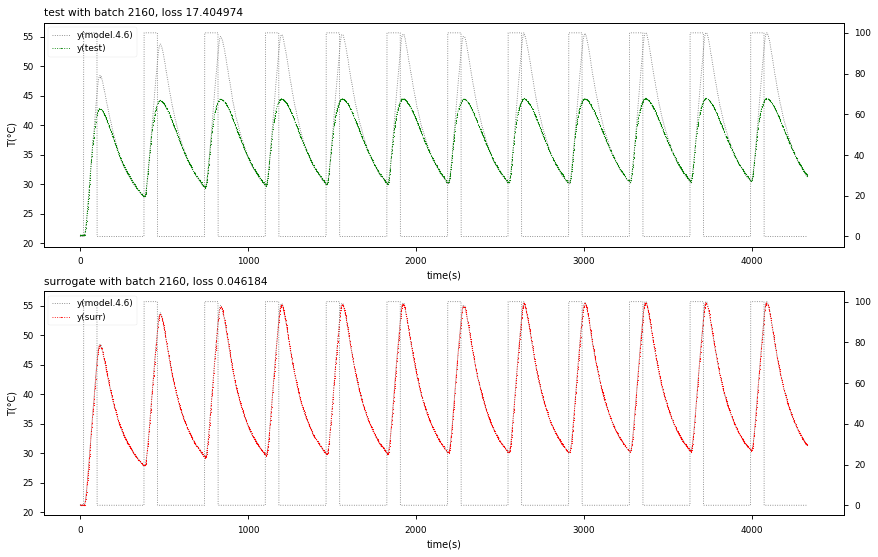

In [20]:
ts = t2.numpy().flatten()
us = u2.numpy().flatten()
ys = y2.numpy().flatten()

plot_test_(ts,us,ys,
          yy=[y_test2,y_bala2],
          loss=[l_test2,l_bala2],
          indizes=batch_i2,
          size=batch_size_test2,
          name=name2
          )